## Review of obsids already observed with MS flag ignored for entire observation

In the context of continuing our evaluation of permanently disabling / ignoring the multiple star flag, we have reviewed the data from two observations which have already been observed with the MS flag disabled for the full guide / tracking interval.  

I confirmed manually that these obsids have the multiple star flag status msid 'AOACIMSS' set to 'DISA' for the full observation durations in telemetry.

In [2]:
obsids = [17198, 18718]

We then have 3 questions to answer about these observations which are explored in this notebook:
   - Was the multiple star flag correctly ignored during the observation?
   - Are the centroid residuals reasonable?
   - Did the attitude error remain reasonable?

In [1]:
from itertools import izip, count
from kadi import events
from Ska.engarchive import fetch
from Ska.Matplotlib import plot_cxctime
from Chandra.Time import DateTime
import Ska.quatutil
import agasc
from astropy.table import Table
from mica.quaternion import Quat
from mica.starcheck import get_starcheck_catalog

# Run from within a local repo of https://github.com/sot/aca_status_flags
# after ingesting the two observations of interest
import analysis_plots

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Was the multple star flag correctly ignored during the observation?

To evaluate this, I have used the multiple star flag data and compared the expected number of stars used in the Kalman filter with and without the multiple star flag to the number of stars *actually* used in the Kalman filter (AOKALSTR).



In [3]:
# Use a local routine to recompute the residuals using the PCAD data that does not need interpolating
# (instead of the interpolated data used for the centroid plots in the analysis_plots data)
def deltas_vs_obc_quat(telem, times, catalog):
    q_att = Quat(np.array([telem['AOATTQT1'].vals,
                           telem['AOATTQT2'].vals,
                           telem['AOATTQT3'].vals,
                           telem['AOATTQT4'].vals]).transpose())
    Ts = q_att.transform

    # Compute the multiplicative factor to convert from the AGASC proper motion
    # field to degrees.  The AGASC PM is specified in milliarcsecs / year, so this
    # is dyear * (degrees / milliarcsec)
    agasc_equinox = DateTime('2000:001:00:00:00.000')
    dyear = (DateTime(times[0]) - agasc_equinox) / 365.25
    pm_to_degrees = dyear / (3600. * 1000.)
    R2A = 206264.81

    dy = {}
    dz = {}
    for slot in range(0, 8):
        row = catalog[catalog['slot'] == slot]
        if not len(row):
            continue
        agasc_id = row[0]['id']
        star = agasc.get_star(agasc_id)
        ra = star['RA']
        dec = star['DEC']
        if star['PM_RA'] != -9999:
            ra = star['RA'] + star['PM_RA'] * pm_to_degrees
        if star['PM_DEC'] != -9999:
            dec = star['DEC'] + star['PM_DEC'] * pm_to_degrees
        star_pos_eci = Ska.quatutil.radec2eci(ra, dec)
        d_aca = np.dot(Ts.transpose(0, 2, 1),
                       star_pos_eci)
        yag = np.arctan2(d_aca[:, 1], d_aca[:, 0]) * R2A
        zag = np.arctan2(d_aca[:, 2], d_aca[:, 0]) * R2A
        dy[slot] = telem['AOACYAN{}'.format(slot)].vals - yag
        dz[slot] = telem['AOACZAN{}'.format(slot)].vals - zag
    return dy, dz
 

def residuals(obsid, slot_data):
    starcheck = get_starcheck_catalog(int(obsid))
    if 'cat' not in starcheck:
        raise ValueError('No starcheck catalog found for {}'.format(obsid))
    catalog = Table(starcheck['cat'])
    catalog.sort('idx')
    # Filter the catalog to be just guide stars
    catalog = catalog[(catalog['type'] == 'BOT') | (catalog['type'] == 'GUI')]
    return deltas_vs_obc_quat(slot_data, slot_data['AOATTQT1'].times, catalog)
    

def get_combined_errs(slot_data, residuals, slots, flags):
    """
    For a given fetch multi-msid structure, a list of slots, and a list of flags,
    get the sum on any time slice of the stars that are either not tracked or have bad status
    """
    bad_sum = np.zeros(len(slot_data['AOACIMS3']))
    for slot in slots:
        not_ok = (slot_data["AOACFCT{}".format(slot)].vals != 'TRAK').astype(int)
        for msid in flags:
            not_ok = not_ok | (slot_data["{}{}".format(msid, slot)].vals != 'OK ').astype(int)
        # exclude centroids with residuals > 20 arcsecs in y or z
        not_ok = not_ok | (np.abs(residuals[0][slot]) > 20)
        not_ok = not_ok | (np.abs(residuals[1][slot]) > 20)
        bad_sum = bad_sum + not_ok
    return bad_sum

In [4]:
quat_msids = ['AOATTQT1', 'AOATTQT2', 'AOATTQT3', 'AOATTQT4']
msids = ['AOACIMS', 'AOACISP', 'AOACIIR', 'AOACFCT', 'AOACYAN', 'AOACZAN']
slots = [3, 4, 5, 6, 7]
slot_msids = ['{}{}'.format(msid, slot) for slot in slots for msid in msids]

def kalman_plots(obsid):
    manvr = events.manvrs.filter(obsid=obsid)[0]
    dwell = events.dwells.filter(obsid=obsid)[0]
    obsdat = analysis_plots.get_obsid_data(obsid)
    slot_data = fetch.MSIDset(quat_msids + slot_msids, manvr.kalman_start, dwell.stop)
    dys, dzs = residuals(obsid, slot_data)

    # How many slots would not be used in Kalman if respecting the MS flag
    bad_sum_with_ms = get_combined_errs(slot_data, (dys, dzs), slots, ['AOACIMS', 'AOACIIR', 'AOACISP'])
    # How many slots actually/expected to be excluded from Kalman based only on flags and track status
    bad_sum_no_ms = get_combined_errs(slot_data, (dys, dzs), slots, ['AOACIIR', 'AOACISP'])

    figure(figsize(16, 3))
    subplot(1, 4, 1)
    plot(5 - bad_sum_with_ms)
    title("{} {}".format(obsid, 'Kalman stars if MS used'))
    ylim(0,5)
    subplot(1, 4, 2)
    plot(5 - bad_sum_no_ms)
    title("{} {}".format(obsid, "Expected Kalman stars"))
    ylim(0,5)
    # This is largely consistent with what is actually seen in the KALSTR data
    kalstr_data = fetch.Msid('AOKALSTR', manvr.kalman_start, dwell.stop)
    subplot(1, 4, 3)
    kalstr_data.plot()
    ylim(ymin=0, ymax=5)
    title("Actual {} {}".format(obsid, "AOKALSTR"))
    delta_kalstr = kalstr_data.vals.astype(int) - (5 - bad_sum_no_ms)
    subplot(1, 4, 4)
    plot(delta_kalstr)
    margins(y=.1)
    title("{} {}".format(obsid, "Observed - Expected N Kalman Stars"))

## The Expected and Actual data are consistent.

The count of expected centroids matches AOKALSTR for obsid 17198.  There's a brief interval where these values do not match exactly.

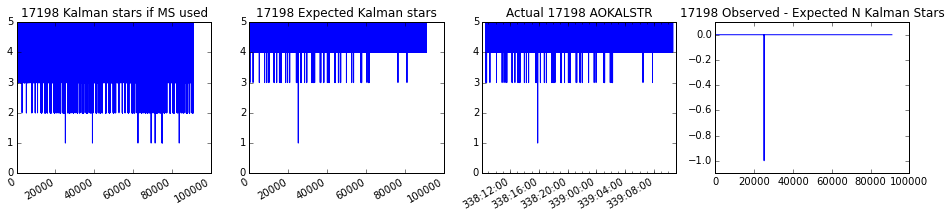

In [16]:
kalman_plots(17198)

The counts of expected centroids and actual centroids match exactly for obsid 18718.


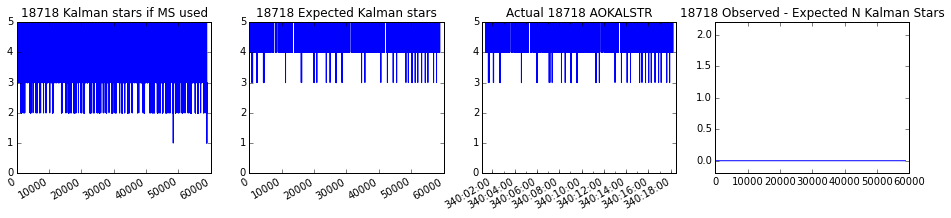

In [6]:
kalman_plots(18718)

##   Are the centroid residuals reasonable?

Yes.  Largely.  For obsid 17198, the data shows that the centroids were perturbed for an interval, and some of these perturbed centroids would have been included in Kalman.

2016-02-15 12:53:44,071: Slot 3: 45042 values: y_sig=0.25 y_std=0.28 z_sig=0.34 z_std=0.32
2016-02-15 12:53:44,077: Slot 4: 44872 values: y_sig=0.58 y_std=0.68 z_sig=0.67 z_std=0.73
2016-02-15 12:53:44,083: Slot 5: 44764 values: y_sig=0.34 y_std=0.34 z_sig=0.21 z_std=0.23
2016-02-15 12:53:44,088: Slot 6: 44962 values: y_sig=0.52 y_std=0.56 z_sig=0.59 z_std=0.54
2016-02-15 12:53:44,094: Slot 7: 44755 values: y_sig=0.39 y_std=0.41 z_sig=0.42 z_std=0.47


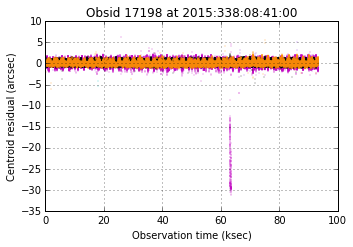

In [7]:
# Here the plot_centroids routine takes an obsid and options describing how to use the flags to use to filter the 
# plotted centroids.  Here centroids are excluded if they have saturated pixel or ionizing radiation set, but
# defective pixel and multiple star flags are not used in the plot filtering.  This is consistent with the 
# configuration onboard for these observations.
analysis_plots.plot_centroids(17198, sp=False, ir=False, dp=None, ms=None);

The centroids for obsid 18718 show no large residuals and are nominal.

2016-02-15 12:53:44,569: Slot 3: 29232 values: y_sig=0.26 y_std=0.29 z_sig=0.37 z_std=0.35
2016-02-15 12:53:44,574: Slot 4: 28928 values: y_sig=0.61 y_std=0.67 z_sig=0.72 z_std=0.76
2016-02-15 12:53:44,578: Slot 5: 29026 values: y_sig=0.33 y_std=0.32 z_sig=0.21 z_std=0.23
2016-02-15 12:53:44,582: Slot 6: 28977 values: y_sig=0.56 y_std=0.61 z_sig=0.65 z_std=0.59
2016-02-15 12:53:44,587: Slot 7: 28950 values: y_sig=0.41 y_std=0.44 z_sig=0.42 z_std=0.46


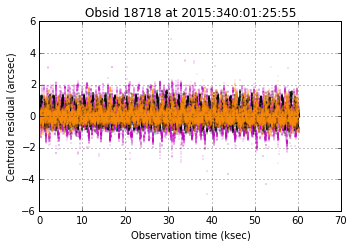

In [8]:
analysis_plots.plot_centroids(18718, sp=False, ir=False, dp=None, ms=None);

##  Did the attitude error remain reasonable?

Inspection of the AOATTER values during the kalman interval does not show anything unreasonable even during the interval of obsid 17198 that was perturbed by a hot pixel.

In [9]:
att_msids = ['AOATTER1', 'AOATTER2', 'AOATTER3']
axis_label = ['roll', 'pitch', 'yaw']
plotrange = [(-30, 30), (-6, 6), (-6, 6)]
bins = [np.arange(-20, 20, 1), np.arange(-4, 4, .25), np.arange(-4, 4, .25)]

In [10]:
def plot_obs_att_errs(obsid):
    manvr = events.manvrs.filter(obsid=obsid)[0]
    dwell = events.dwells.filter(obsid=obsid)[0]
    obs_att_data = fetch.Msidset(att_msids, manvr.kalman_start, dwell.stop)
    figure(figsize=(15, 3))
    for i, msid, label, msidrange in izip(count(1), att_msids, axis_label, plotrange):
        subplot(1, 3, i)
        plot_cxctime(obs_att_data[msid].times, 3600 * np.degrees(obs_att_data[msid].vals), 'b,')
        title("obsid {} {} ({})".format(obsid, msid, label))
        ylabel("arcsec")
        ylim(msidrange)
        margins(x=.1)
        if ((3600 * np.degrees(np.min(obs_att_data[msid].vals)) < msidrange[0])
            or (3600 * np.degrees(np.max(obs_att_data[msid].vals)) > msidrange[1])):
            raise ValueError("Range does not contain all data")

def plot_obs_err_hist(obsid):
    manvr = events.manvrs.filter(obsid=obsid)[0]
    dwell = events.dwells.filter(obsid=obsid)[0]
    obs_att_data = fetch.Msidset(att_msids,
                                 DateTime(manvr.kalman_start).secs + 60,
                                 DateTime(dwell.stop).secs)
    figure(figsize=(15, 3))
    for i, msid, label, msidbin in izip(count(1), att_msids, axis_label, bins):
        subplot(1, 3, i)
        hist(3600 * np.degrees(obs_att_data[msid].vals), bins=msidbin, log=True)
        title("obsid {} {} ({})".format(obsid, msid, label))
        xlabel("arcsec")

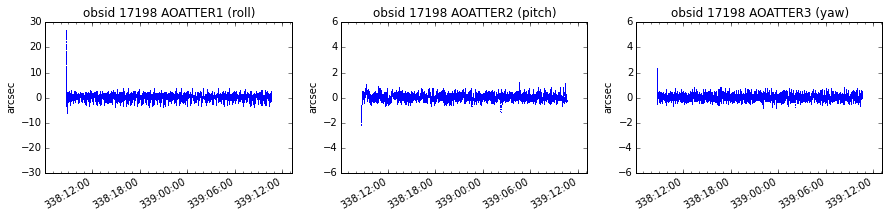

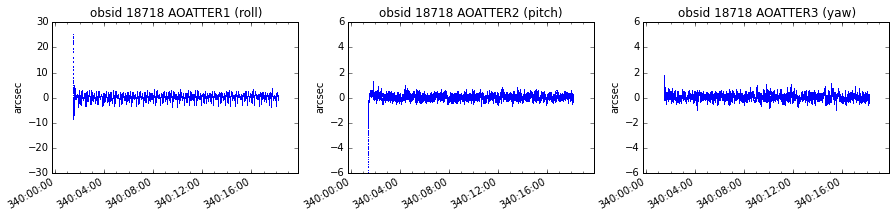

In [11]:
for obsid in obsids:
    plot_obs_att_errs(obsid)

The histograms of the error are reasonable and consistent with the overall error values in Kalman during the last year.  I note one "cheat" here in that the histograms for these two obsids below have had the first 60 seconds trimmed (unlike the time plots above).

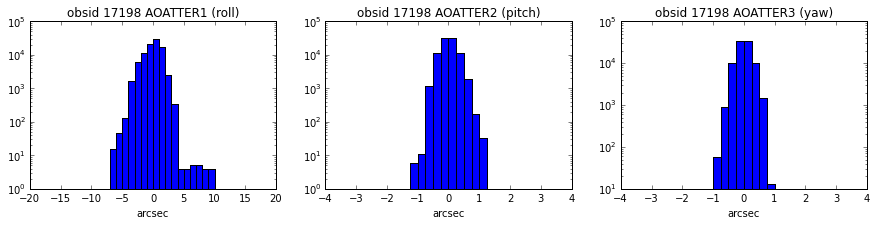

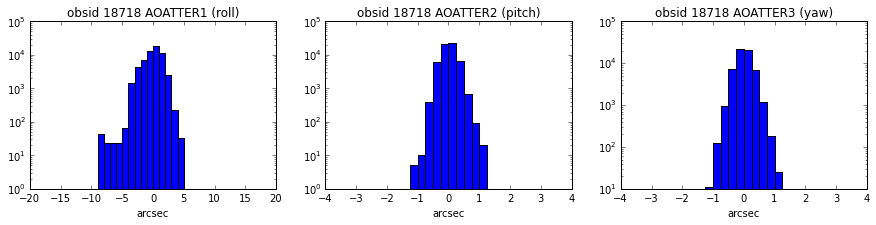

In [12]:
for obsid in obsids:
    plot_obs_err_hist(obsid)

In [13]:
last_year = fetch.Msidset(att_msids, DateTime() - 365, DateTime())
bad_times = ['2015:146:00:00:00 2015:147:00:00:00',
             '2015:244:00:00:00 2015:245:00:00:00']
last_year.filter_bad_times(table=bad_times)

In [14]:
# using the obc rate noise filters as a guide, get "normal" kalman intervals
events.dwells.interval_pad = (-1000, -1000)
events.tsc_moves.interval_pad = (1000, 1000)
events.dumps.interval_pad = (1000, 1000)
for msid in att_msids:
    last_year[msid].select_intervals(events.dwells)
    last_year[msid].remove_intervals(events.tsc_moves)
    last_year[msid].remove_intervals(events.dumps)

Histograms of the error in all "normal" Kalman intervals in the last year, with the first 1000ks trimmed from the beginning and end of each interval.

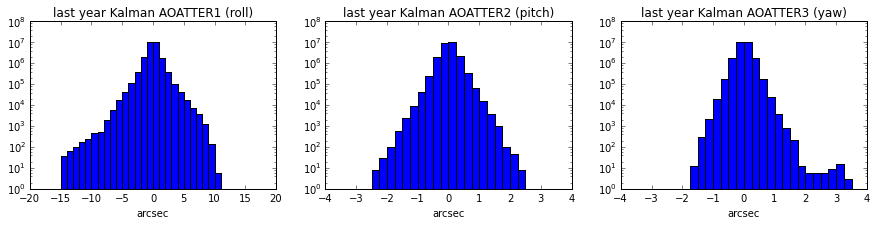

In [15]:
# plot attitude errors
figure(figsize=(15, 3))
for i, msid, label, msidbin in izip(count(1), att_msids, axis_label, bins):
    subplot(1, 3, i)
    hist(3600 * np.degrees(last_year[msid].vals), bins=msidbin, log=True)
    title("last year Kalman {} ({})".format(msid, label))
    xlabel("arcsec")
